This notebook provides a short sample on how to evaluate your trained model. We will continue from our previous notebook `03_` which has trained a working MLP. 

The complete evaluation script can be found in the root directory of the repository `eval.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
pl.seed_everything(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_theme(context='paper')

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import model, mlp, cnn, ae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[rank: 0] Global seed set to 42
/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overall benchmark

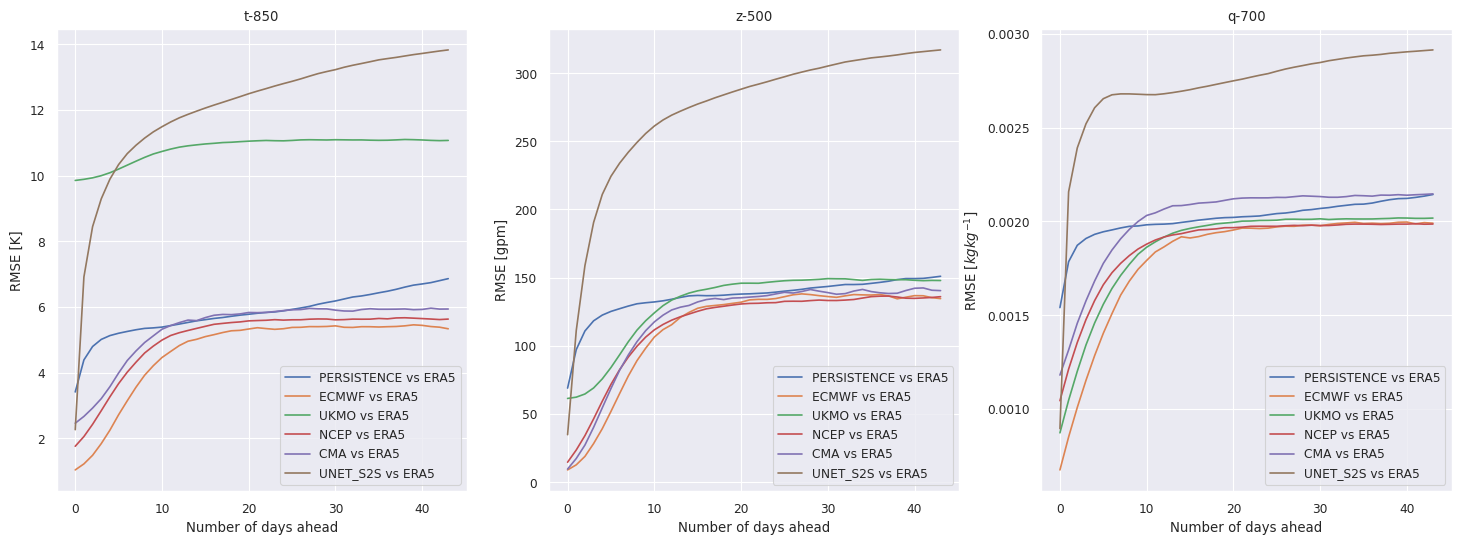

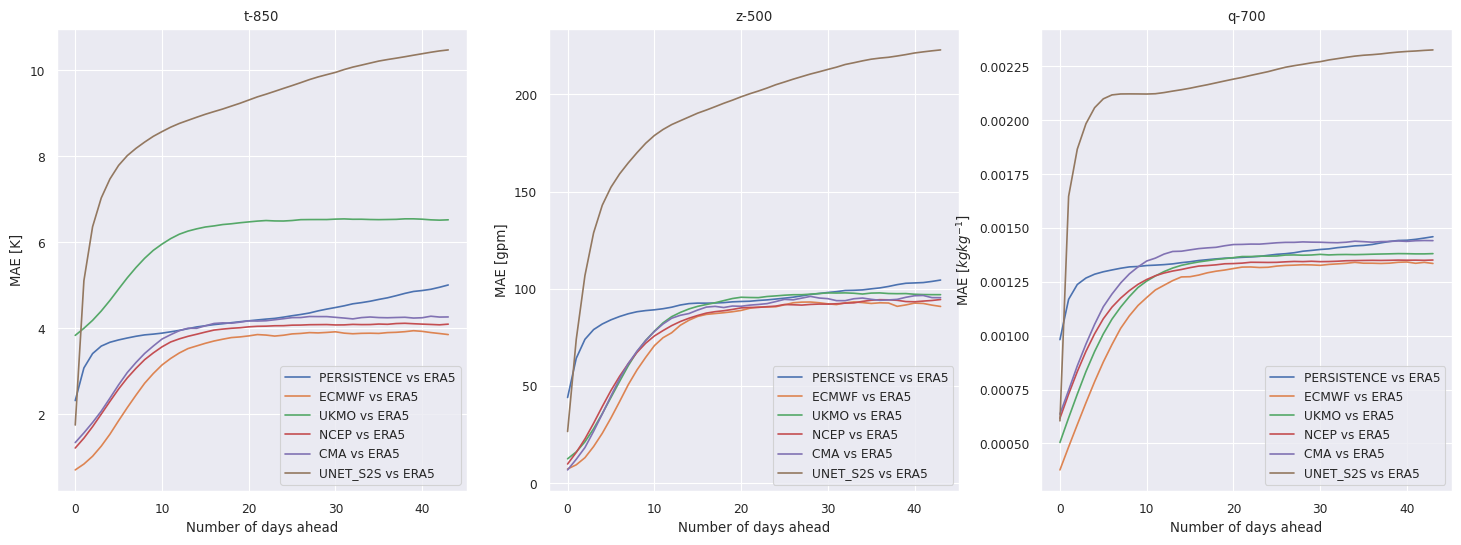

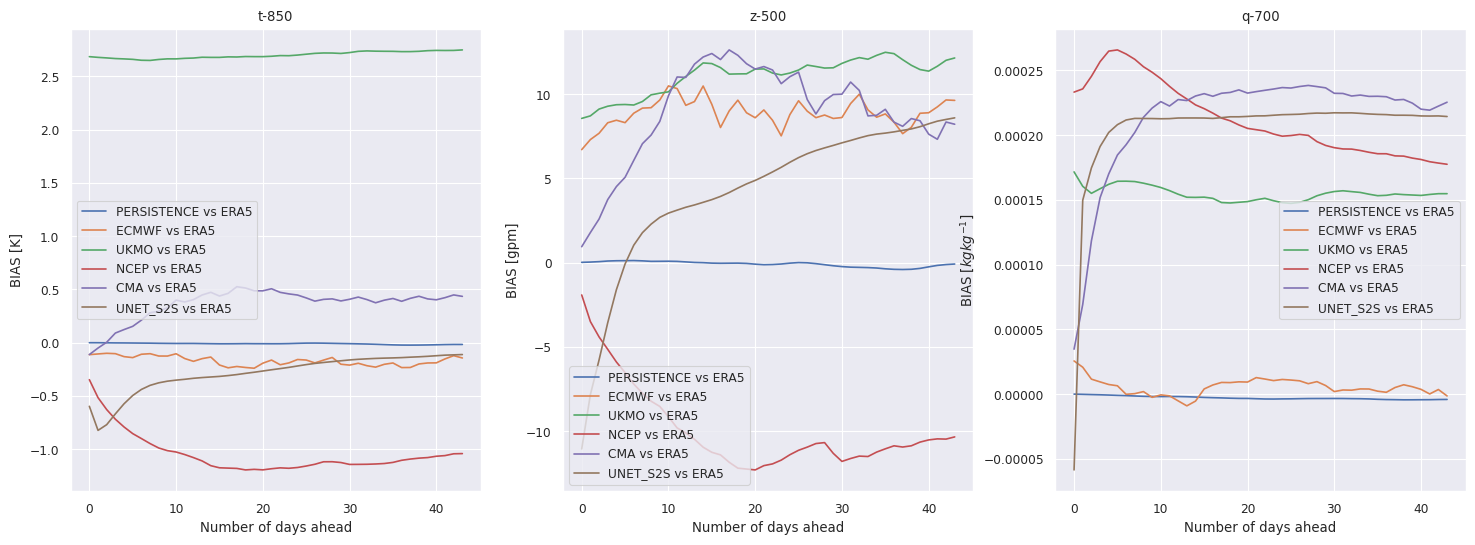

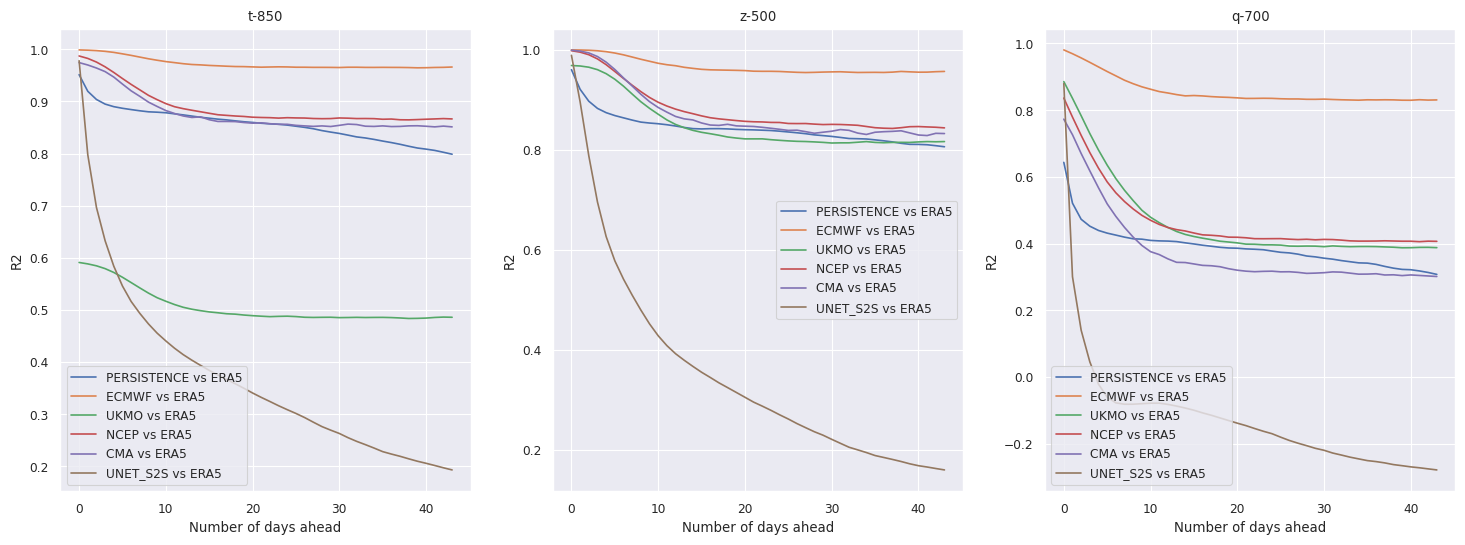

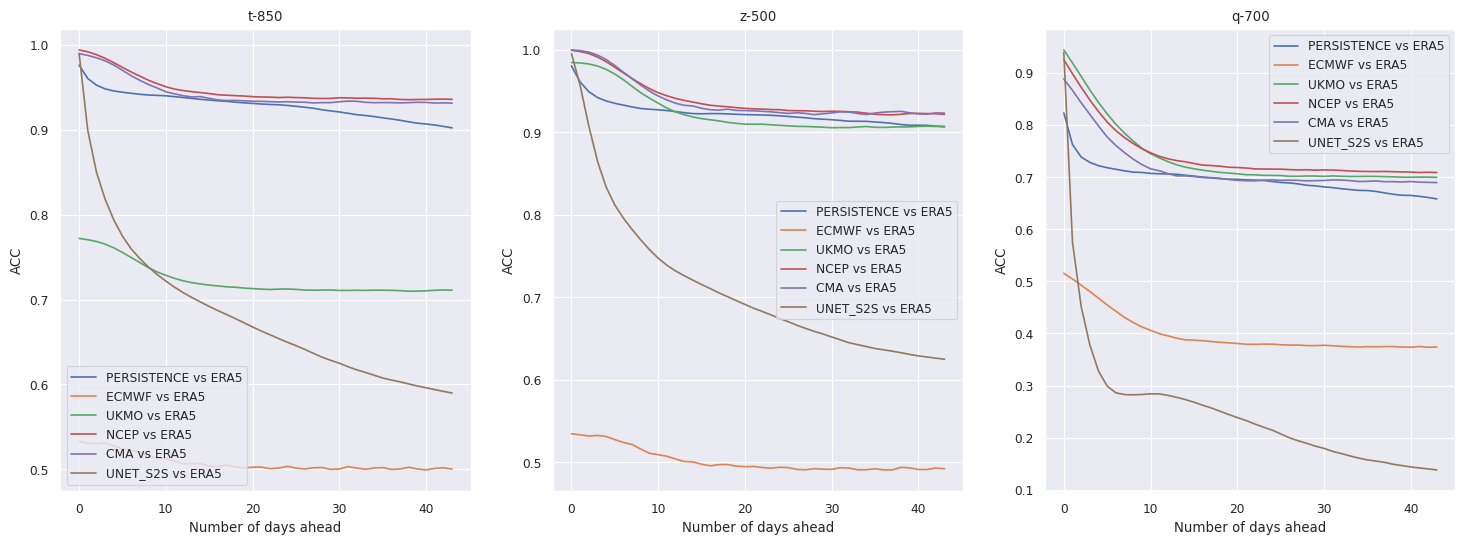

In [3]:
# Plot RMSE over time, across centers
model_names = ['persistence', 'ecmwf', 'ukmo', 'ncep', 'cma', 'unet_s2s']
metrics = ['rmse', 'mae', 'bias', 'r2', 'acc']
headline_vars = dict({'t-850': 'K', 'z-500': 'gpm', 'q-700': r'$kg kg^{-1}$'})


for metric_idx, metric in enumerate(metrics):
    
    f, ax = plt.subplots(1, len(headline_vars), figsize=(6*len(headline_vars), 6))
    
    for model_idx, model_name in enumerate(model_names):
        if 's2s' in model_name:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/version_0/{metric}_{model_name}.csv'))
        else:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            sns.lineplot(
                df[[headline_var]].to_numpy().squeeze(), 
                label=f'{model_name.upper()} vs ERA5',
                ax=ax[headline_idx]
            )
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            if metric in ['r2', 'acc']:
                ax[headline_idx].set_ylabel(f'{metric.upper()}')
            else:
                ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
            
            ax[headline_idx].set_title(f'{headline_var}')

## Prediction visualization

In [4]:
# First we load our model
model_name = 'unet_s2s'

## Load config filepath which consists of all the definition needed to fit/eval a model
log_dir = Path('../logs') / model_name
model_config_filepath = Path(f'../chaosbench/configs/{model_name}.yaml')

with open(model_config_filepath, 'r') as config_filepath:
    hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

## Checkpointing
ckpt_filepath = log_dir / 'lightning_logs/version_0/checkpoints/'
ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
baseline = baseline.load_from_checkpoint(ckpt_filepath)

## Dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

In [5]:
date_idx = 0

## For plotting ##
param = 't'
level = 1000
plot_idx = [1, config.N_STEPS // 2, config.N_STEPS - 1] # [1...config.N_STEPS-1]
all_preds = list()
all_truth = list()
##################

with torch.no_grad():
    
    timestamp, input_x, input_y = input_dataset[date_idx]
    _, output_x, output_y = output_dataset[date_idx]
    
    curr_x = input_x.unsqueeze(0).to(device)
    
    for step_idx in tqdm(range(config.N_STEPS - 1)):
        preds = baseline(curr_x)
        curr_y = output_y.unsqueeze(0)[:, step_idx + 1]
        
        if step_idx + 1 in plot_idx:
            all_preds.append(preds[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())
            all_truth.append(curr_y[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())
            
        curr_x = preds 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [01:32<00:00,  2.11s/it]


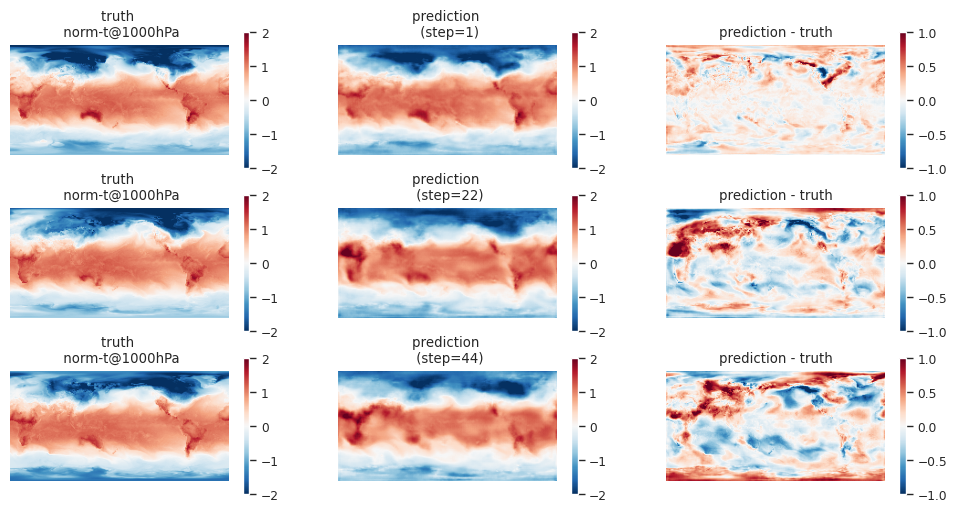

In [6]:
# Plotting
all_preds = np.array(all_preds)
all_truth = np.array(all_truth)

f, ax = plt.subplots(len(plot_idx), 3, figsize=(4 * len(plot_idx), 6))

for time_idx in range(len(plot_idx)):
    
    im0 = ax[time_idx, 0].imshow(all_truth[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    ax[time_idx, 0].set_title(f'truth \n norm-{param}@{level}hPa')
    ax[time_idx, 0].axis('off')
    cbar0 = f.colorbar(im0, ax=ax[time_idx, 0])

    im1 = ax[time_idx, 1].imshow(all_preds[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    ax[time_idx, 1].set_title(f'prediction \n (step={plot_idx[time_idx]})')
    ax[time_idx, 1].axis('off')
    cbar1 = f.colorbar(im1, ax=ax[time_idx, 1])
    
    im2 = ax[time_idx, 2].imshow(all_preds[time_idx] - all_truth[time_idx], cmap='RdBu_r', vmin=-1, vmax=1)
    ax[time_idx, 2].set_title(f'prediction - truth')
    ax[time_idx, 2].axis('off')
    cbar2 = f.colorbar(im2, ax=ax[time_idx, 2])

plt.show();

## Effects of temporal information

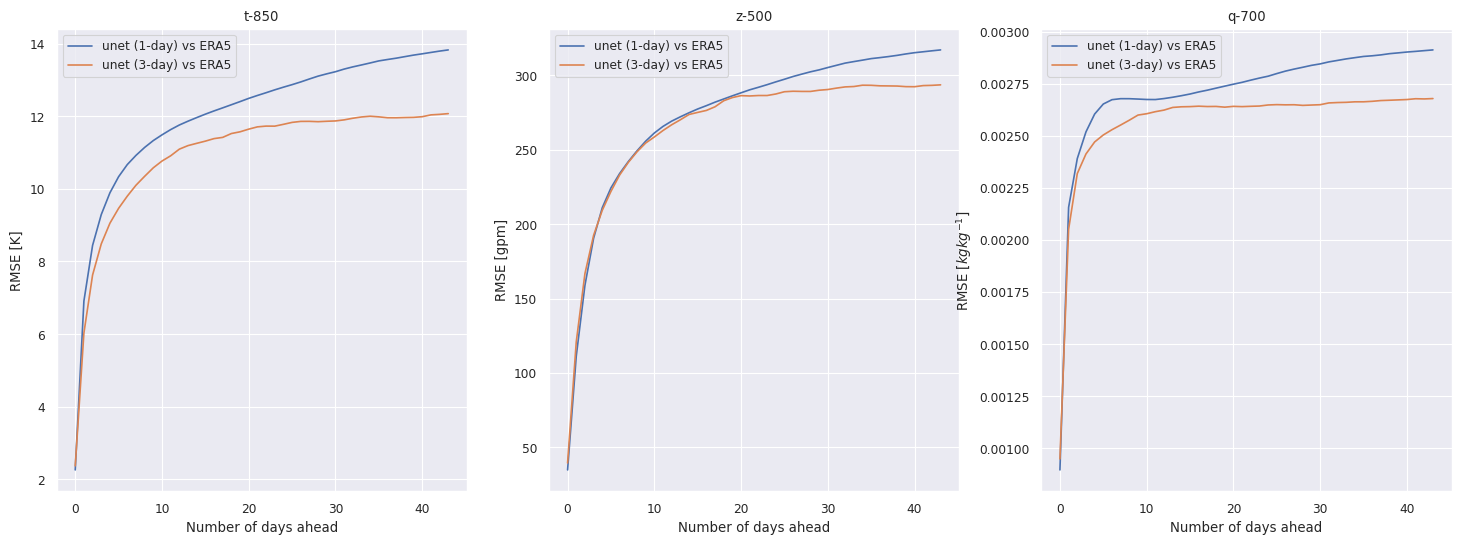

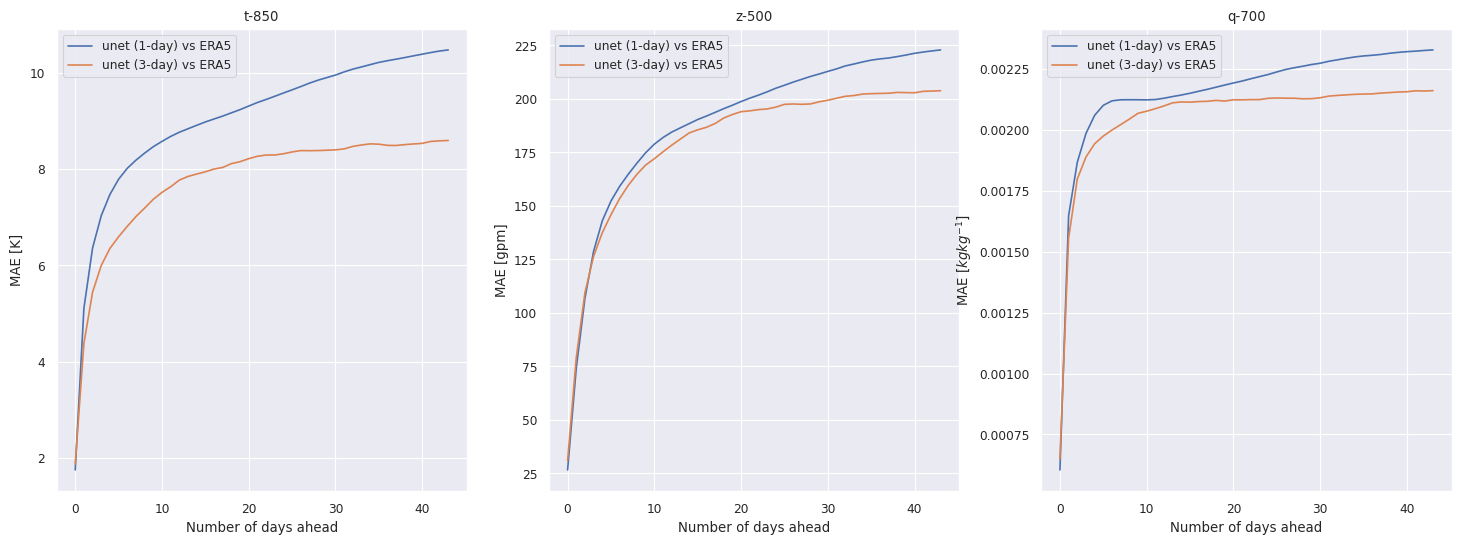

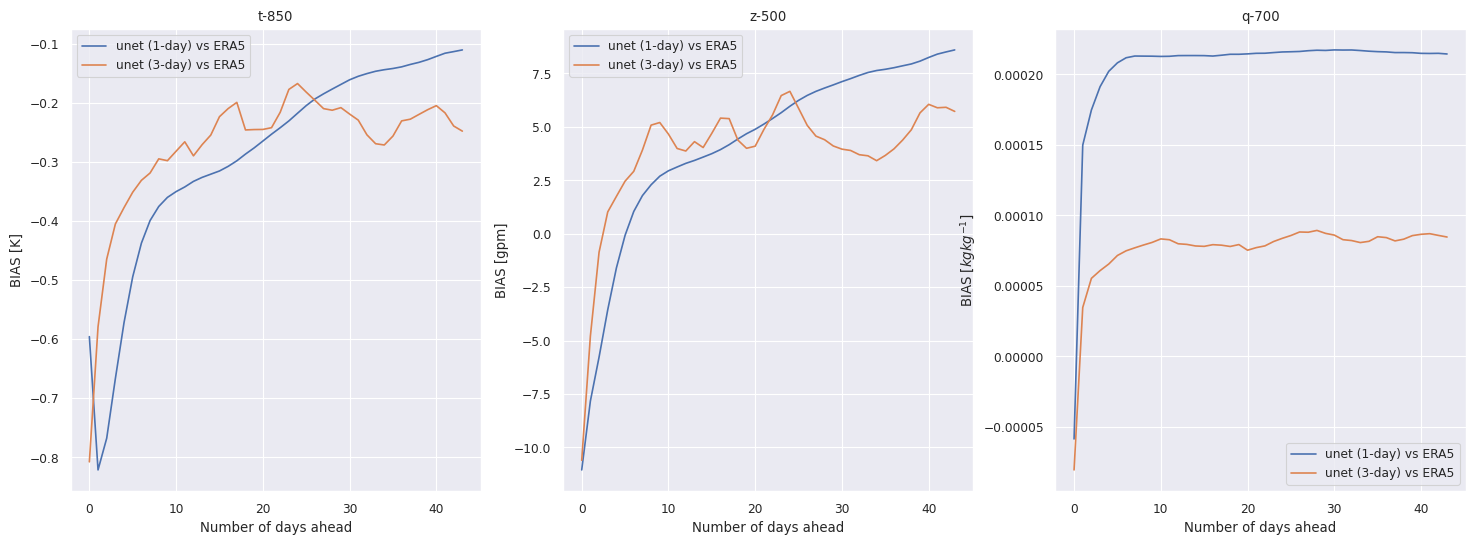

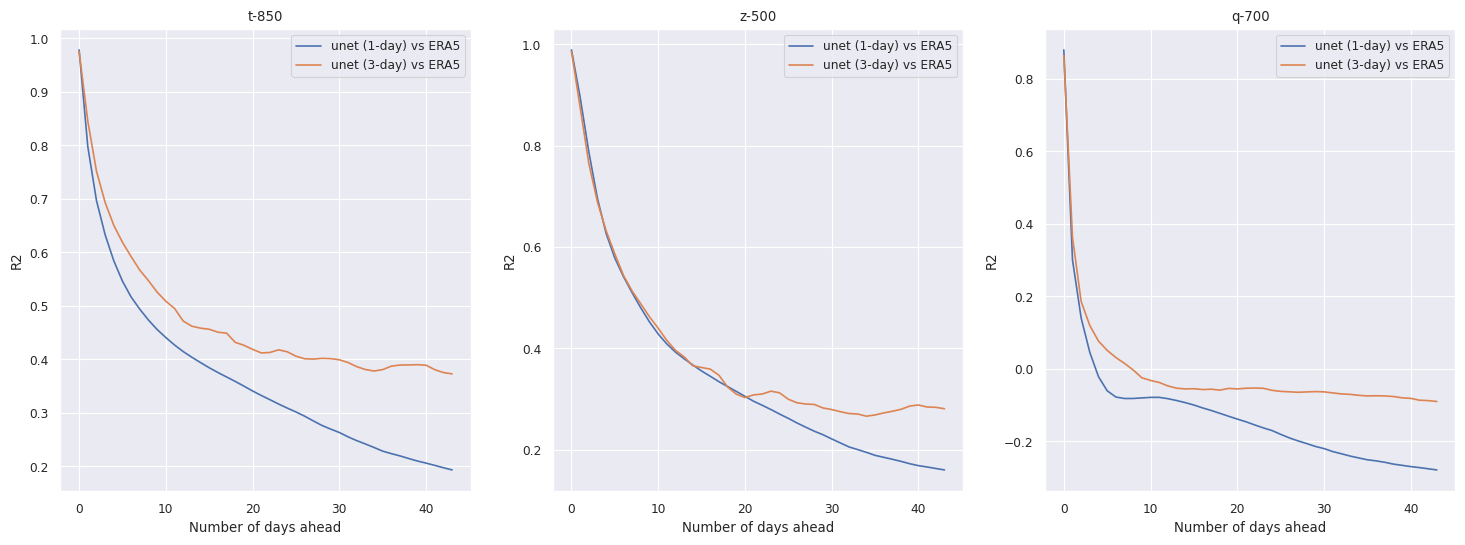

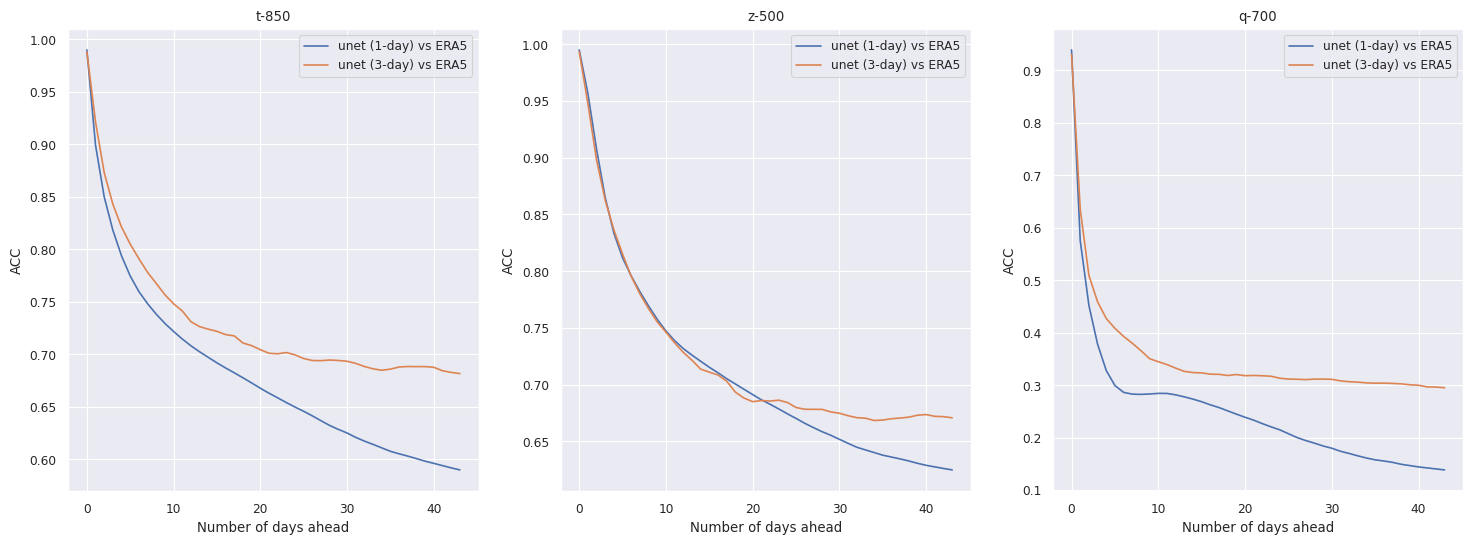

In [7]:
# Plot RMSE over time, across centers
metrics = ['rmse', 'mae', 'bias', 'r2', 'acc']
model_names = dict({'unet (1-day)': 'unet_s2s/version_0', 'unet (3-day)': 'unet_s2s/version_1'})
headline_vars = dict({'t-850': 'K', 'z-500': 'gpm', 'q-700': r'$kg kg^{-1}$'})


for metric_idx, metric in enumerate(metrics):
    
    f, ax = plt.subplots(1, len(headline_vars), figsize=(6*len(headline_vars), 6))
    
    for model_idx, (model_spec, model_name) in enumerate(model_names.items()):
        
        model_name, version_num = model_name.split('/')
        df = pd.read_csv(Path(f'../logs/{model_name}/eval/{version_num}/{metric}_{model_name}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            
            sns.lineplot(
                df[[headline_var]].to_numpy().squeeze(), 
                label=f'{model_spec} vs ERA5',
                ax=ax[headline_idx]
            )
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            if metric in ['r2', 'acc']:
                ax[headline_idx].set_ylabel(f'{metric.upper()}')
            else:
                ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
            
            ax[headline_idx].set_title(f'{headline_var}')